# Introducción

Modelo de detección de sesgo

Para este análisis utilizamos el modelo [`d4data/bias-detection-model`](https://huggingface.co/d4data/bias-detection-model), entrenado para clasificar oraciones en inglés como `biased` (sesgadas) o `not_biased` (no sesgadas).

El modelo devuelve:
- Un **label** (`biased` o `not_biased`)
- Un **score** que representa la **probabilidad de sesgo** (si el label es `biased`, un score de 0.90 indica alta confianza en que el texto contiene sesgo).

Usaremos este `score` como **medida continua del sesgo** para visualizar su relación con las categorías `harmful` y `helpful`.

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

In [3]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
from tqdm import tqdm


## Funciones de utilidad

In [22]:
# Configuración general de estilo para matplotlib
plt.rcParams.update({
    'font.size': 16,  # Tamaño base de fuente
    'axes.titlesize': 16,  # Tamaño de títulos de subplots
    'axes.labelsize': 16,  # Tamaño de etiquetas de ejes
    'xtick.labelsize': 15,  # Tamaño de etiquetas del eje x
    'ytick.labelsize': 15,  # Tamaño de etiquetas del eje y
    'figure.titlesize': 20  # Tamaño del título principal
})

## Cargar datasets

In [4]:
cols_to_use = ['question', 'category']

qrels_2020 = pd.read_csv("datasets/qrels/qrels_2020.csv", usecols=cols_to_use)
qrels_2021 = pd.read_csv("datasets/qrels/qrels_2021.csv", usecols=cols_to_use)
qrels_2022 = pd.read_csv("datasets/qrels/qrels_2022.csv", usecols=cols_to_use)

In [8]:
qrels_2020

,category,question
0,harmful,Can vitamin D cure COVID-19?
1,harmful,Can vitamin D cure COVID-19?
2,harmful,Can vitamin D cure COVID-19?
3,harmful,Can vitamin D cure COVID-19?
4,harmful,Can vitamin D cure COVID-19?
...,...,...
7251,helpful,Can drinking lemon water prevent COVID-19?
7252,helpful,Can drinking lemon water prevent COVID-19?
7253,helpful,Can drinking lemon water prevent COVID-19?
7254,helpful,Can drinking lemon water prevent COVID-19?


# Bias-detection-model

## Cargar y probar el modelo

In [5]:
#MODELO
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability

classifier("The irony, of course, is that the exhibit that invites people to throw trash at vacuuming Ivanka Trump lookalike reflects every stereotype feminists claim to stand against, oversexualizing Ivanka’s body and ignoring her hard work.")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


[{'label': 'Biased', 'score': 0.9819144606590271}]

El modelo nos indica que ha detectado un alto nivel de sesgo en esa frase con un score del 98%, lo cual tiene mucho sentido dado el contenido del texto.

## Aplicar el modelo

El siguiente paso será aplicar el modelo sobre nuestros Qrels. Calcularemos el sesgo de cada 'Question' y añadiremos:
- Una nueva columna con la predicción del modelo (bias_label).
- Una nueva columna con el score del modelo (bias_score).

### 2020

In [6]:
# Aplicamos el modelo a cada pregunta
bias_labels = []
bias_scores = []

for question in tqdm(qrels_2020["question"], desc="Analizando bias..."): # tqdm para barra de progreso
    result = classifier(question)[0]
    bias_labels.append(result["label"])
    bias_scores.append(result["score"])

# Añadir nuevas columnas
qrels_2020["bias_label"] = bias_labels
qrels_2020["bias_score"] = bias_scores

Analizando bias...:   0%|          | 0/7256 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Analizando bias...: 100%|██████████| 7256/7256 [06:44<00:00, 17.92it/s]


### 2021

In [9]:
#MODELO
tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
model = TFAutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model")
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability

# Aplicamos el modelo a cada pregunta
bias_labels = []
bias_scores = []

for question in tqdm(qrels_2021["question"], desc="Analizando bias..."): 
    result = classifier(question)[0]
    bias_labels.append(result["label"])
    bias_scores.append(result["score"])

# Añadir nuevas columnas
qrels_2021["bias_label"] = bias_labels
qrels_2021["bias_score"] = bias_scores

Analizando bias...: 100%|██████████| 6469/6469 [04:08<00:00, 26.00it/s]


### 2022

In [11]:
# Aplicamos el modelo a cada pregunta
bias_labels = []
bias_scores = []

for question in tqdm(qrels_2022["question"], desc="Analizando bias..."): # tqdm para barra de progreso
    result = classifier(question)[0]
    bias_labels.append(result["label"])
    bias_scores.append(result["score"])

# Añadir nuevas columnas
qrels_2022["bias_label"] = bias_labels
qrels_2022["bias_score"] = bias_scores

Analizando bias...: 100%|██████████| 6501/6501 [04:01<00:00, 26.97it/s]


Guardamos los resultados para no tener que volver a ejecutar el modelo.

In [12]:
qrels_2020_bias = qrels_2020
qrels_2021_bias = qrels_2021
qrels_2022_bias = qrels_2022

In [13]:
qrels_2020_bias.to_csv("datasets/bias/qrels_2020_bias.csv", index=False)
qrels_2021_bias.to_csv("datasets/bias/qrels_2021_bias.csv", index=False)
qrels_2022_bias.to_csv("datasets/bias/qrels_2022_bias.csv", index=False)

# IMPORT AQUI

In [23]:
qrels_2020_bias = pd.read_csv("datasets/bias/qrels_2020_bias.csv")
qrels_2021_bias = pd.read_csv("datasets/bias/qrels_2021_bias.csv")
qrels_2022_bias = pd.read_csv("datasets/bias/qrels_2022_bias.csv")

In [24]:
qrels_2020_bias

,question,category,bias_label,bias_score
0,Can vitamin D cure COVID-19?,harmful,Non-biased,0.593567
1,Can vitamin D cure COVID-19?,harmful,Non-biased,0.593567
2,Can vitamin D cure COVID-19?,harmful,Non-biased,0.593567
3,Can vitamin D cure COVID-19?,harmful,Non-biased,0.593567
4,Can vitamin D cure COVID-19?,harmful,Non-biased,0.593567
...,...,...,...,...
7251,Can drinking lemon water prevent COVID-19?,helpful,Biased,0.505911
7252,Can drinking lemon water prevent COVID-19?,helpful,Biased,0.505911
7253,Can drinking lemon water prevent COVID-19?,helpful,Biased,0.505911
7254,Can drinking lemon water prevent COVID-19?,helpful,Biased,0.505911


# Análisis de sesgos

## 2020

### Histogramas

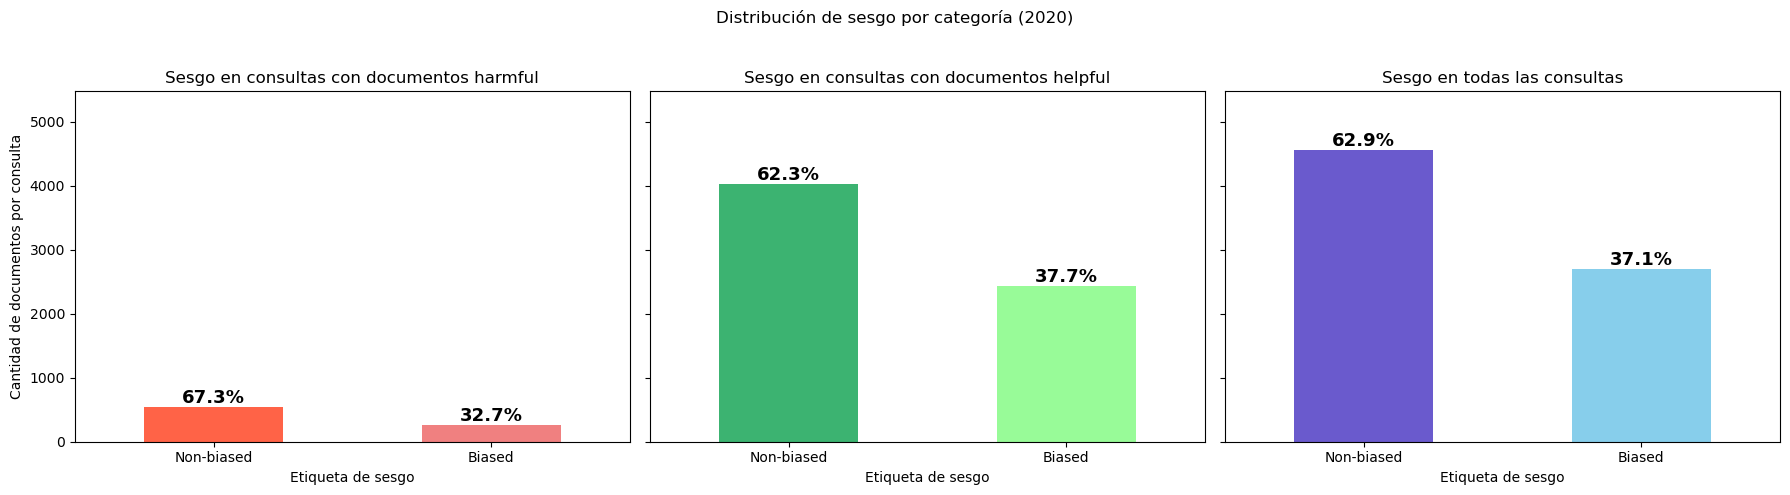

In [13]:
# Crear los 3 histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

def add_percentages(ax, counts):
    total = sum(counts)
    max_height = max(counts)
    ax.set_ylim(0, max_height * 1.2)
    for i, v in enumerate(counts):
        percentage = (v / total) * 100
        ax.text(i, v, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=13, fontweight='bold')


# Harmful
harmful_counts = qrels_2020_bias[qrels_2020_bias["category"] == "harmful"]["bias_label"].value_counts()
harmful_counts.plot(kind="bar", ax=axes[0], color=["tomato", "lightcoral"])
add_percentages(axes[0], harmful_counts)
axes[0].set_title("Sesgo en consultas con documentos harmful")
axes[0].set_xlabel("Etiqueta de sesgo")
axes[0].set_ylabel("Cantidad de documentos por consulta")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Helpful
helpful_counts = qrels_2020_bias[qrels_2020_bias["category"] == "helpful"]["bias_label"].value_counts()
helpful_counts.plot(kind="bar", ax=axes[1], color=["mediumseagreen", "palegreen"])
add_percentages(axes[1], helpful_counts)
axes[1].set_title("Sesgo en consultas con documentos helpful")
axes[1].set_xlabel("Etiqueta de sesgo")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Ambos
total_counts = qrels_2020_bias["bias_label"].value_counts()
total_counts.plot(kind="bar", ax=axes[2], color=["slateblue", "skyblue"])
add_percentages(axes[2], total_counts)
axes[2].set_title("Sesgo en todas las consultas")
axes[2].set_xlabel("Etiqueta de sesgo")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle("Distribución de sesgo por categoría (2020)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
print(len(qrels_2020_bias[qrels_2020_bias["category"] == "harmful"]))
print(len(qrels_2020_bias[qrels_2020_bias["category"] == "helpful"]))

805
6451


### Dispersión

In [15]:
# Redondeamos bias_score a 2 decimales para agrupar
qrels_2020_bias["bias_score"] = qrels_2020_bias["bias_score"].round(2)

bias_grouped_2020 = qrels_2020_bias.groupby(["bias_score", "category"]).size().unstack().fillna(0).reset_index()

In [16]:
bias_grouped_2020

category,bias_score,harmful,helpful
0,0.51,16.0,209.0
1,0.52,30.0,536.0
2,0.53,12.0,201.0
3,0.54,187.0,835.0
4,0.55,39.0,29.0
5,0.56,20.0,670.0
6,0.57,85.0,326.0
7,0.58,0.0,106.0
8,0.59,53.0,566.0
9,0.63,160.0,206.0


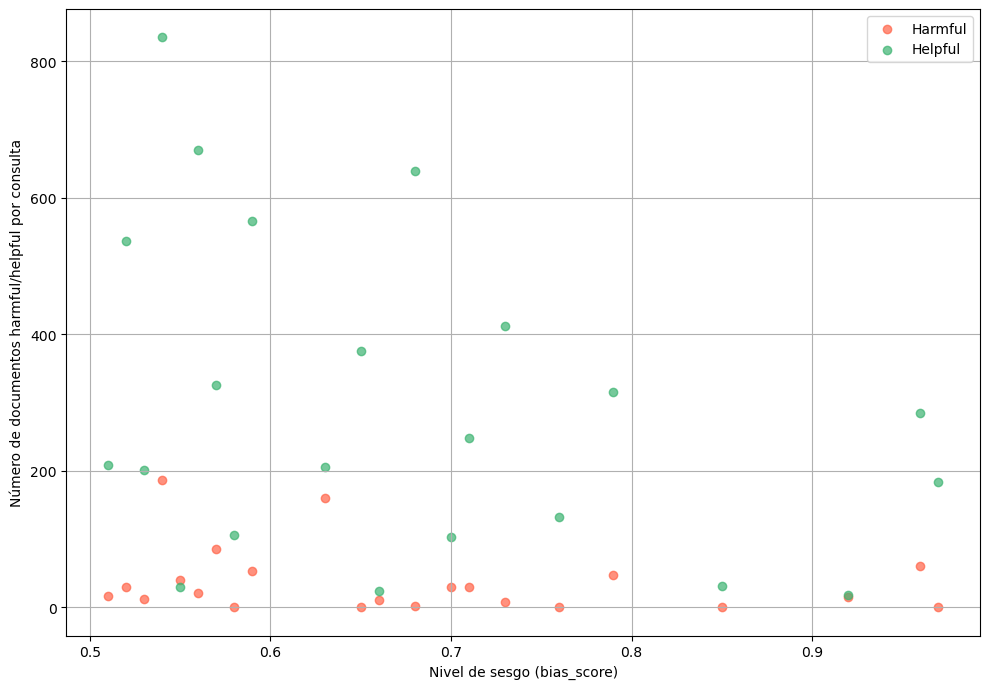

In [17]:
plt.figure(figsize=(10, 7))
plt.scatter(bias_grouped_2020["bias_score"], bias_grouped_2020["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(bias_grouped_2020["bias_score"], bias_grouped_2020["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.xlabel("Nivel de sesgo (bias_score)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

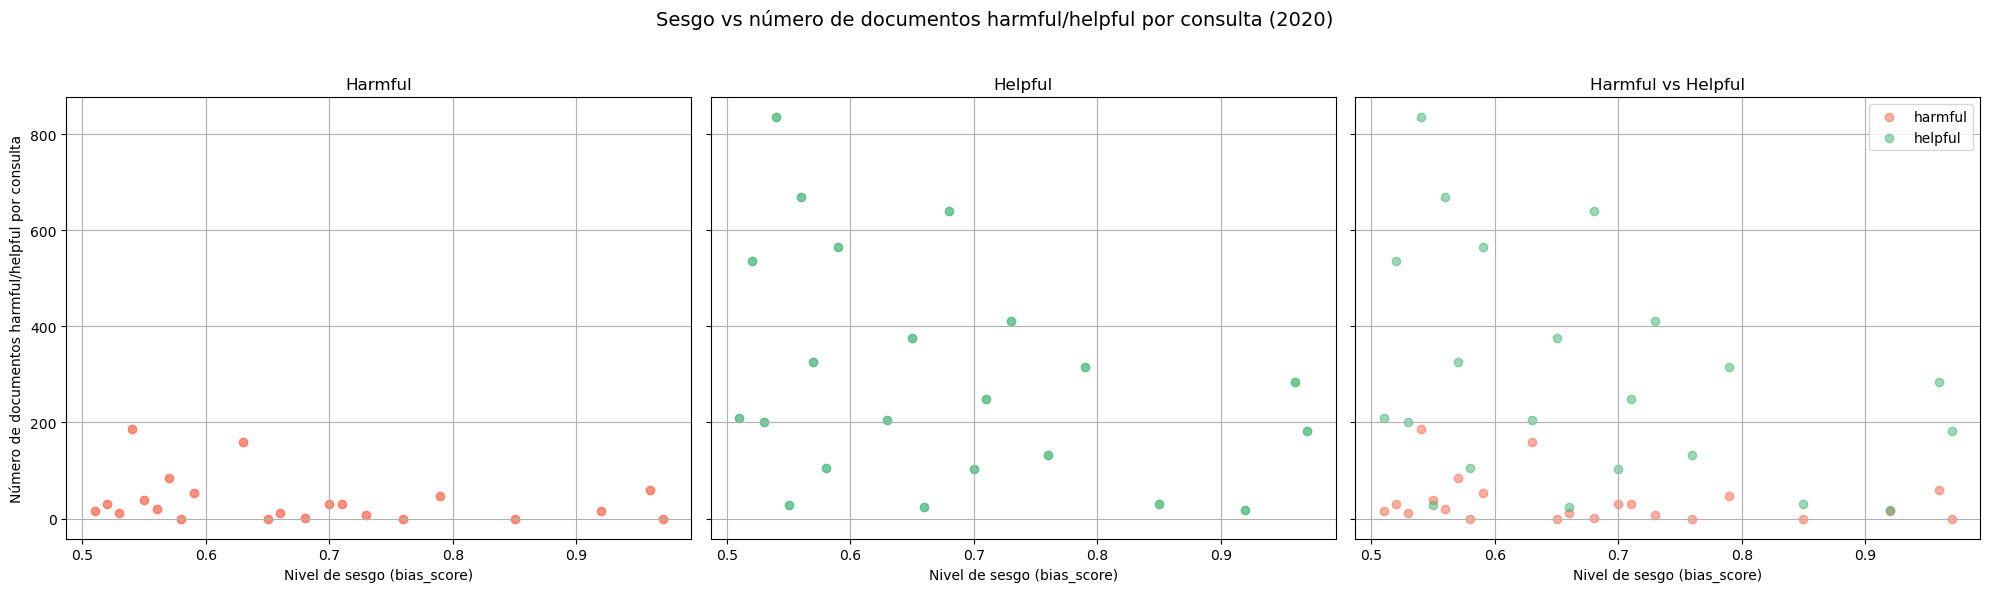

In [18]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Gráfico 1: harmful
axes[0].scatter(bias_grouped_2020["bias_score"], bias_grouped_2020["harmful"], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Nivel de sesgo (bias_score)")
axes[0].set_ylabel("Número de documentos harmful/helpful por consulta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(bias_grouped_2020['bias_score'], bias_grouped_2020['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Nivel de sesgo (bias_score)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(bias_grouped_2020['bias_score'], bias_grouped_2020['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(bias_grouped_2020['bias_score'], bias_grouped_2020['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Nivel de sesgo (bias_score)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Sesgo vs número de documentos harmful/helpful por consulta (2020)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Correlaciones

In [19]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(bias_grouped_2020["bias_score"], bias_grouped_2020["harmful"])[0],
        "harmful (Spearman)": spearmanr(bias_grouped_2020["bias_score"], bias_grouped_2020["harmful"])[0],
        "helpful (Pearson)": pearsonr(bias_grouped_2020["bias_score"], bias_grouped_2020["helpful"])[0],
        "helpful (Spearman)": spearmanr(bias_grouped_2020["bias_score"], bias_grouped_2020["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre sesgo (bias_score) y número de documentos harmful/helpful por consulta (2020)")
plt.tight_layout()
plt.show()

NameError: name 'pearsonr' is not defined

## 2021

### Histogramas

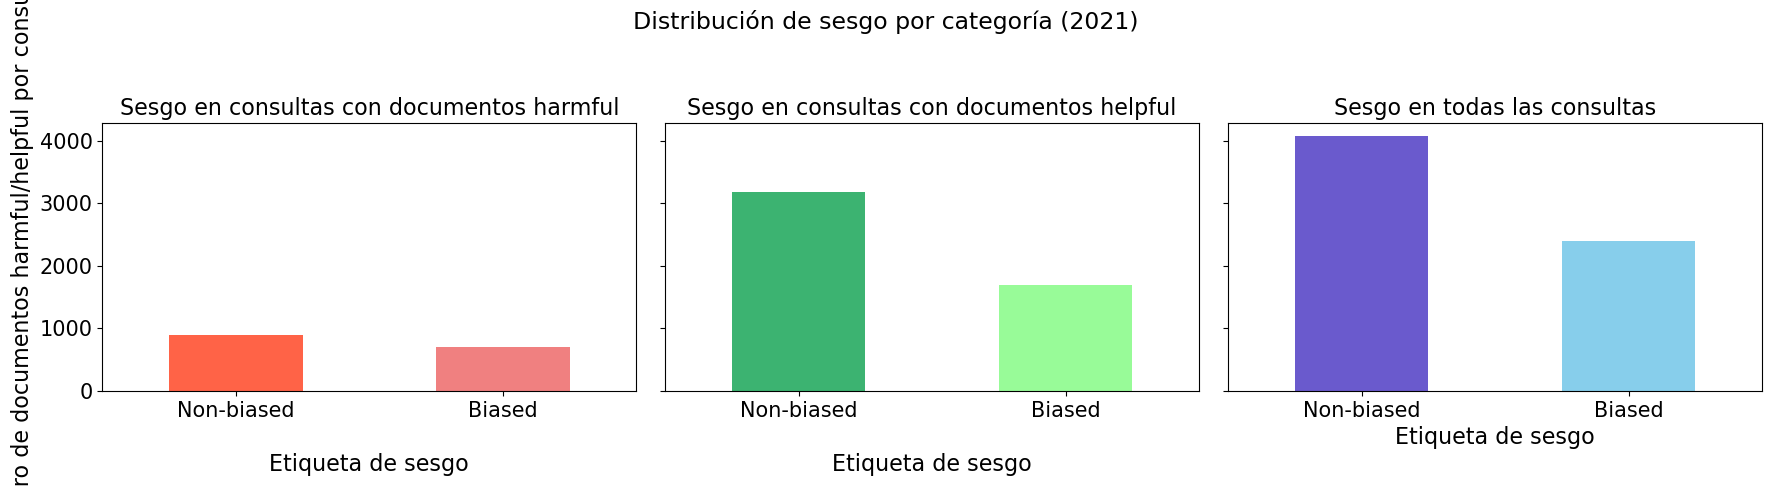

In [174]:
# Crear los 3 histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Harmful
qrels_2021_bias[qrels_2021_bias["category"] == "harmful"]["bias_label"].value_counts().plot(
    kind="bar", ax=axes[0], color=["tomato", "lightcoral"]
)
axes[0].set_title("Sesgo en consultas con documentos harmful", fontsize=16)
axes[0].set_xlabel("\nEtiqueta de sesgo", fontsize=16)
axes[0].set_ylabel("Número de documentos harmful/helpful por consulta", fontsize=16)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Helpful
qrels_2021_bias[qrels_2021_bias["category"] == "helpful"]["bias_label"].value_counts().plot(
    kind="bar", ax=axes[1], color=["mediumseagreen", "palegreen"]
)
axes[1].set_title("Sesgo en consultas con documentos helpful", fontsize=16)
axes[1].set_xlabel("\nEtiqueta de sesgo", fontsize=16)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Ambos
qrels_2021_bias["bias_label"].value_counts().plot(
    kind="bar", ax=axes[2], color=["slateblue", "skyblue"]
)
axes[2].set_title("Sesgo en todas las consultas", fontsize=16)
axes[2].set_xlabel("Etiqueta de sesgo", fontsize=16)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle("Distribución de sesgo por categoría (2021)", fontsize=17)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Volvemos a tener clases desbalanceadas.

### Dispersión

In [175]:
# Redondeamos bias_score a 2 decimales para agrupar
qrels_2021_bias["bias_score"] = qrels_2021_bias["bias_score"].round(2)

bias_grouped_2021 = qrels_2021_bias.groupby(["bias_score", "category"]).size().unstack().fillna(0).reset_index()

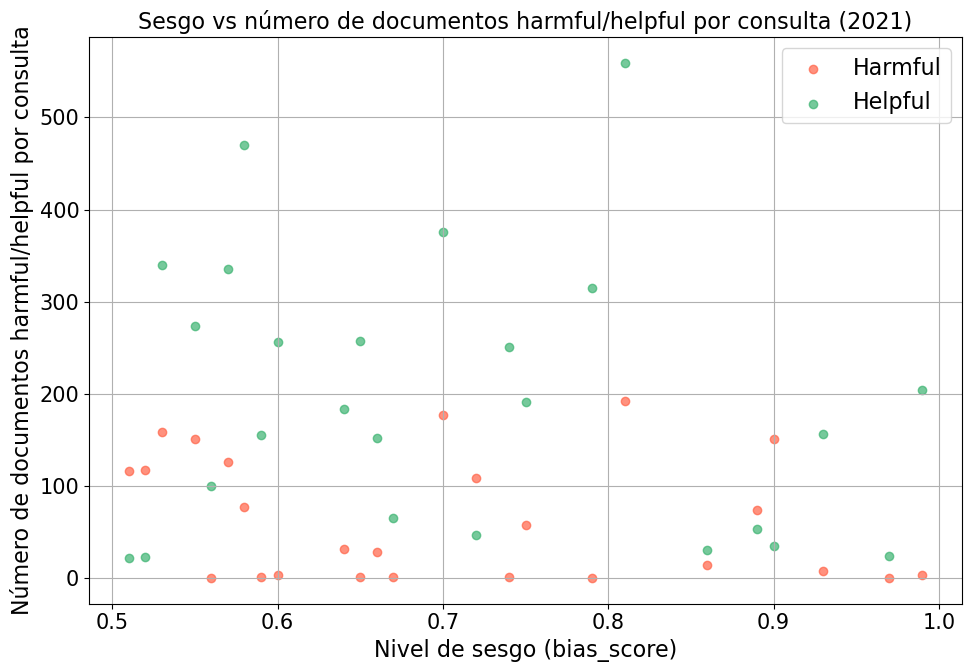

In [187]:
plt.figure(figsize=(10, 7))
plt.scatter(bias_grouped_2021["bias_score"], bias_grouped_2021["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(bias_grouped_2021["bias_score"], bias_grouped_2021["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Sesgo vs número de documentos harmful/helpful por consulta (2021)")
plt.xlabel("Nivel de sesgo (bias_score)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

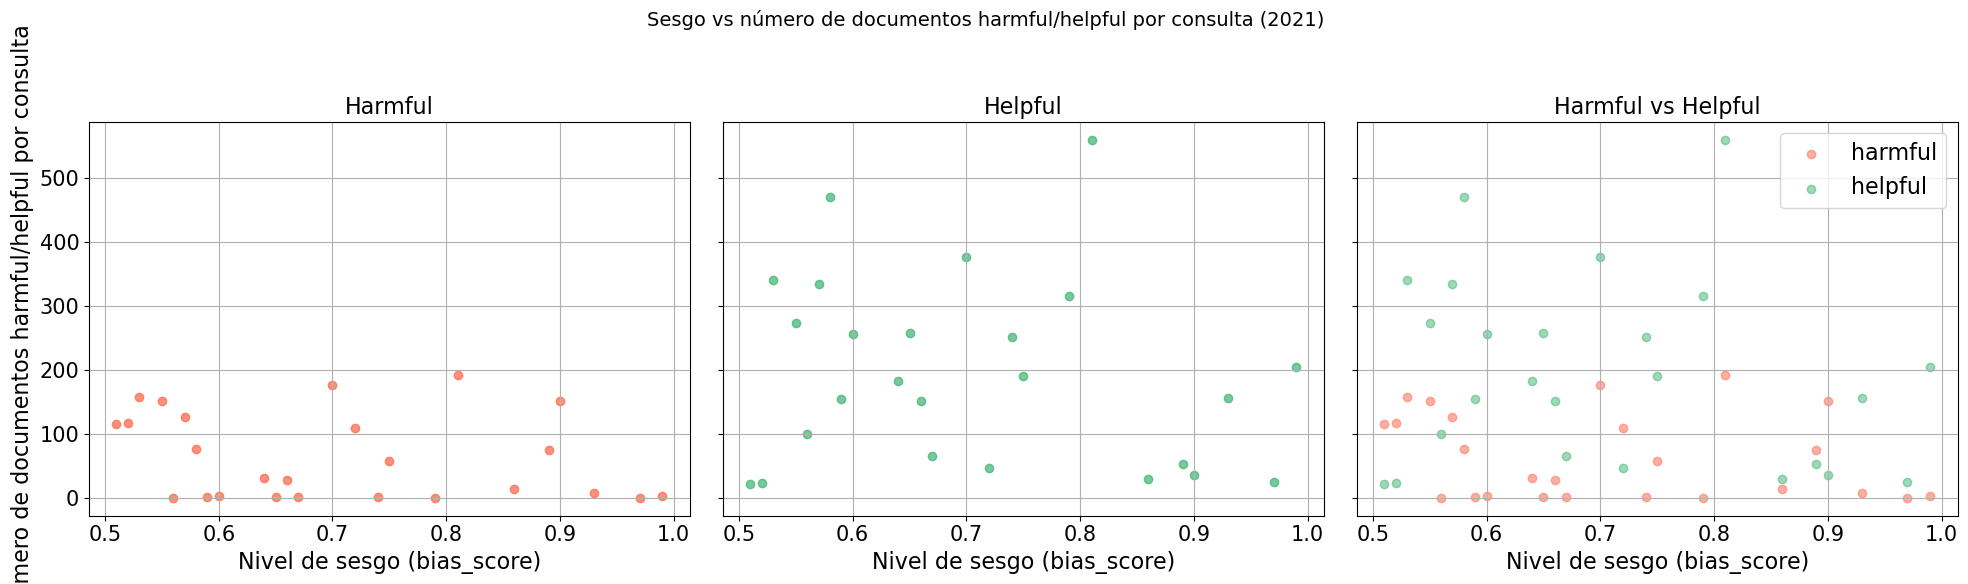

In [177]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Gráfico 1: harmful
axes[0].scatter(bias_grouped_2021["bias_score"], bias_grouped_2021["harmful"], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Nivel de sesgo (bias_score)")
axes[0].set_ylabel("Número de documentos harmful/helpful por consulta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(bias_grouped_2021['bias_score'], bias_grouped_2021['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Nivel de sesgo (bias_score)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(bias_grouped_2021['bias_score'], bias_grouped_2021['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(bias_grouped_2021['bias_score'], bias_grouped_2021['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Nivel de sesgo (bias_score)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Sesgo vs número de documentos harmful/helpful por consulta (2021)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Correlaciones

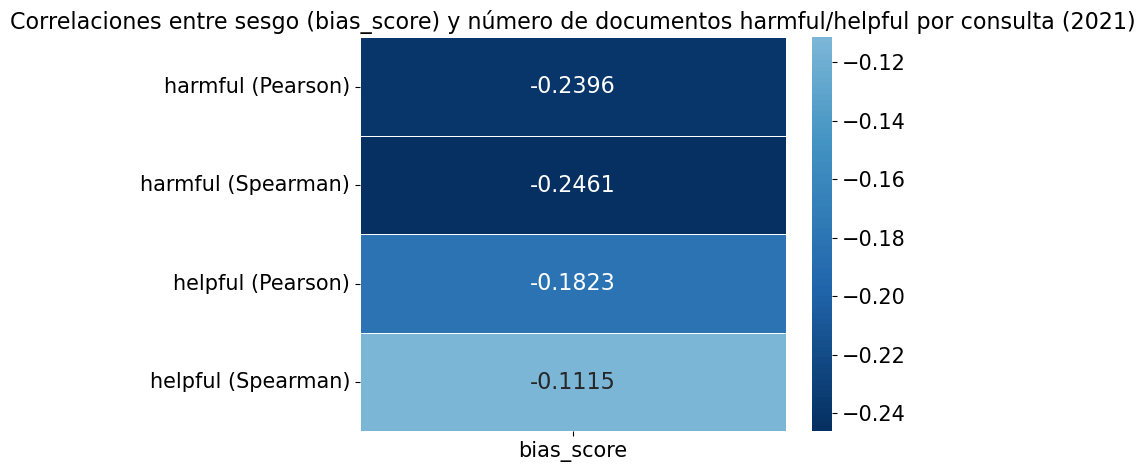

In [178]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(bias_grouped_2021["bias_score"], bias_grouped_2021["harmful"])[0],
        "harmful (Spearman)": spearmanr(bias_grouped_2021["bias_score"], bias_grouped_2021["harmful"])[0],
        "helpful (Pearson)": pearsonr(bias_grouped_2021["bias_score"], bias_grouped_2021["helpful"])[0],
        "helpful (Spearman)": spearmanr(bias_grouped_2021["bias_score"], bias_grouped_2021["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre sesgo (bias_score) y número de documentos harmful/helpful por consulta (2021)")
plt.tight_layout()
plt.show()

## 2022

### Histogramas

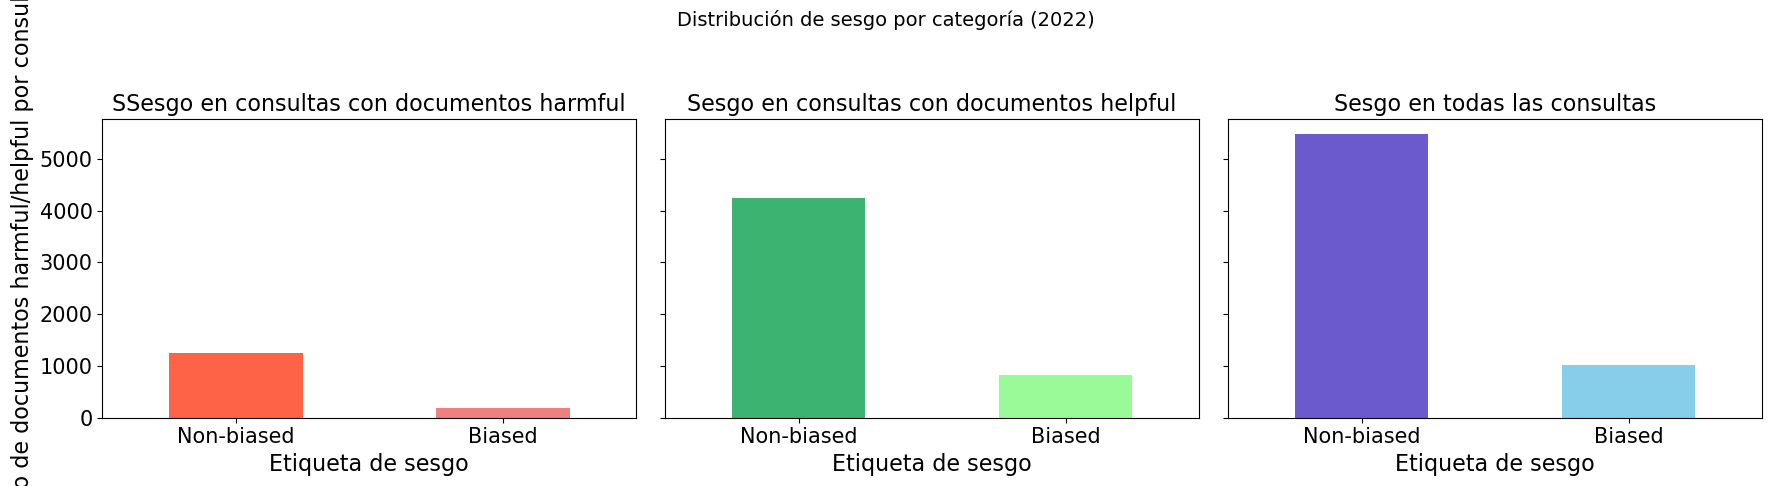

In [179]:
# Crear los 3 histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Harmful
qrels_2022_bias[qrels_2022_bias["category"] == "harmful"]["bias_label"].value_counts().plot(
    kind="bar", ax=axes[0], color=["tomato", "lightcoral"]
)
axes[0].set_title("SSesgo en consultas con documentos harmful")
axes[0].set_xlabel("Etiqueta de sesgo")
axes[0].set_ylabel("Número de documentos harmful/helpful por consulta")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Helpful
qrels_2022_bias[qrels_2022_bias["category"] == "helpful"]["bias_label"].value_counts().plot(
    kind="bar", ax=axes[1], color=["mediumseagreen", "palegreen"]
)
axes[1].set_title("Sesgo en consultas con documentos helpful")
axes[1].set_xlabel("Etiqueta de sesgo")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Ambos
qrels_2022_bias["bias_label"].value_counts().plot(
    kind="bar", ax=axes[2], color=["slateblue", "skyblue"]
)
axes[2].set_title("Sesgo en todas las consultas")
axes[2].set_xlabel("Etiqueta de sesgo")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle("Distribución de sesgo por categoría (2022)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Dispersión

In [180]:
# Redondeamos bias_score a 2 decimales para agrupar
qrels_2022_bias["bias_score"] = qrels_2022_bias["bias_score"].round(2)

bias_grouped_2022 = qrels_2022_bias.groupby(["bias_score", "category"]).size().unstack().fillna(0).reset_index()

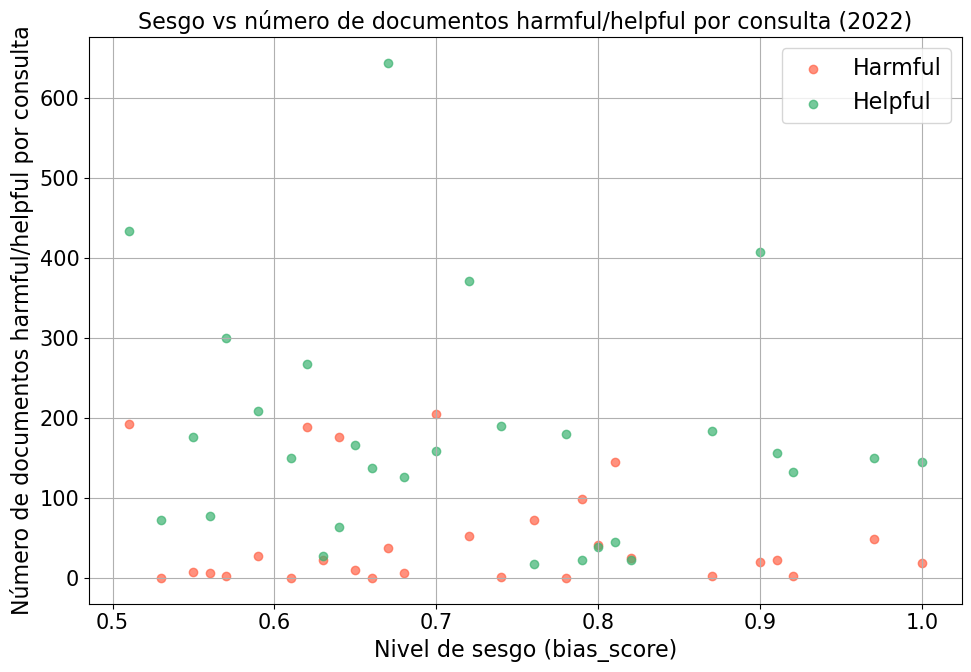

In [189]:
plt.figure(figsize=(10, 7))
plt.scatter(bias_grouped_2022["bias_score"], bias_grouped_2022["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(bias_grouped_2022["bias_score"], bias_grouped_2022["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Sesgo vs número de documentos harmful/helpful por consulta (2022)")
plt.xlabel("Nivel de sesgo (bias_score)")
plt.ylabel("Número de documentos harmful/helpful por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

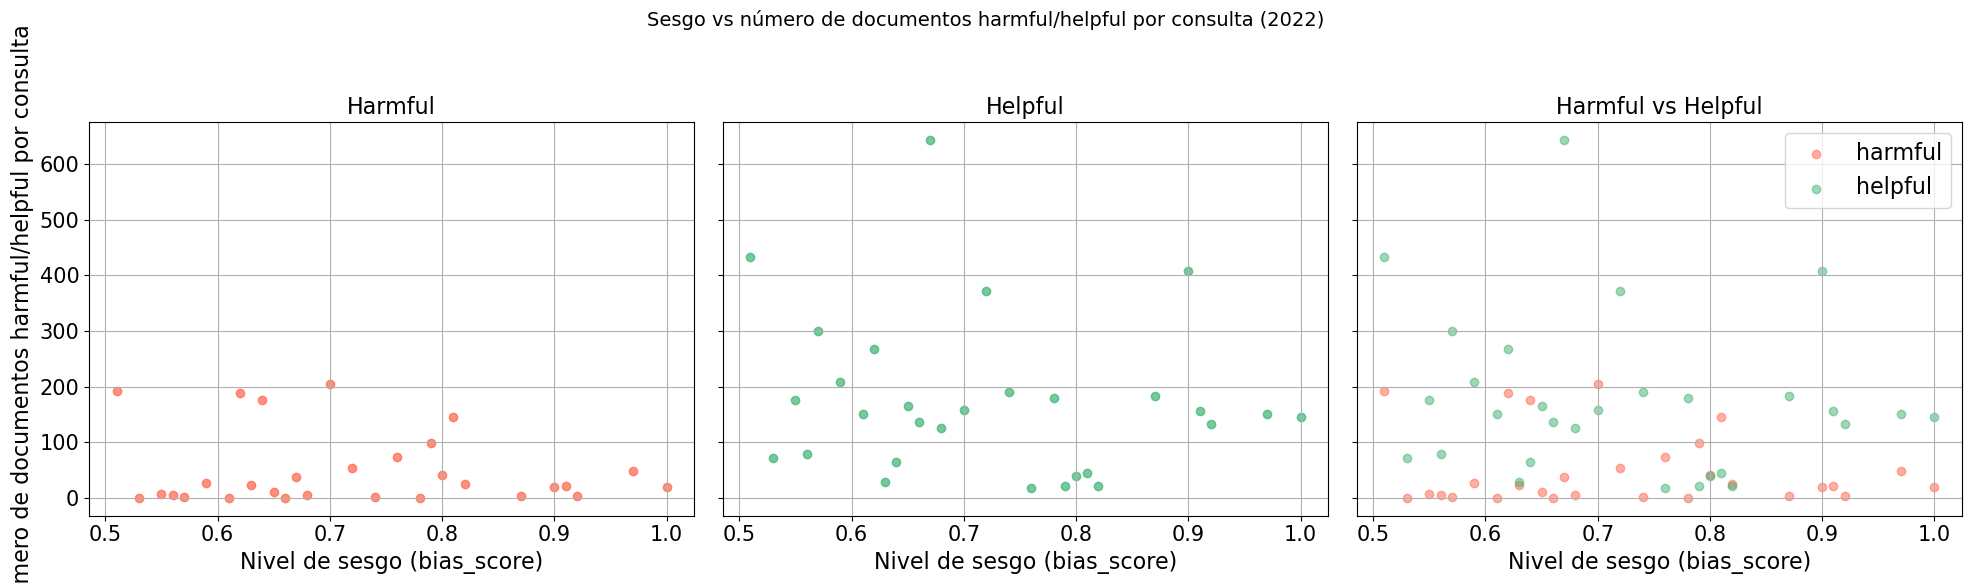

In [182]:

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Gráfico 1: harmful
axes[0].scatter(bias_grouped_2022["bias_score"], bias_grouped_2022["harmful"], color='tomato', alpha=0.7)
axes[0].set_title("Harmful")
axes[0].set_xlabel("Nivel de sesgo (bias_score)")
axes[0].set_ylabel("Número de documentos harmful/helpful por consulta")
axes[0].grid(True)

# Gráfico 2: helpful
axes[1].scatter(bias_grouped_2022['bias_score'], bias_grouped_2022['helpful'], color='mediumseagreen', alpha=0.7)
axes[1].set_title("Helpful")
axes[1].set_xlabel("Nivel de sesgo (bias_score)")
axes[1].grid(True)

# Gráfico 3: Ambos
axes[2].scatter(bias_grouped_2022['bias_score'], bias_grouped_2022['harmful'], label='harmful', color='tomato', alpha=0.5)
axes[2].scatter(bias_grouped_2022['bias_score'], bias_grouped_2022['helpful'], label='helpful', color='mediumseagreen', alpha=0.5)
axes[2].set_title("Harmful vs Helpful")
axes[2].set_xlabel("Nivel de sesgo (bias_score)")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("Sesgo vs número de documentos harmful/helpful por consulta (2022)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Correlaciones

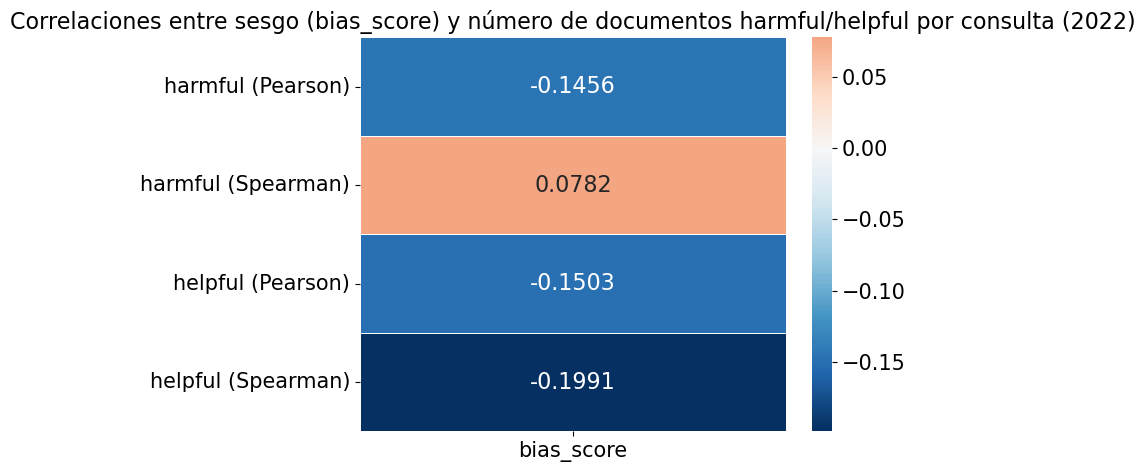

In [183]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(bias_grouped_2022["bias_score"], bias_grouped_2022["harmful"])[0],
        "harmful (Spearman)": spearmanr(bias_grouped_2022["bias_score"], bias_grouped_2022["harmful"])[0],
        "helpful (Pearson)": pearsonr(bias_grouped_2022["bias_score"], bias_grouped_2022["helpful"])[0],
        "helpful (Spearman)": spearmanr(bias_grouped_2022["bias_score"], bias_grouped_2022["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre sesgo (bias_score) y número de documentos harmful/helpful por consulta (2022)")
plt.tight_layout()
plt.show()

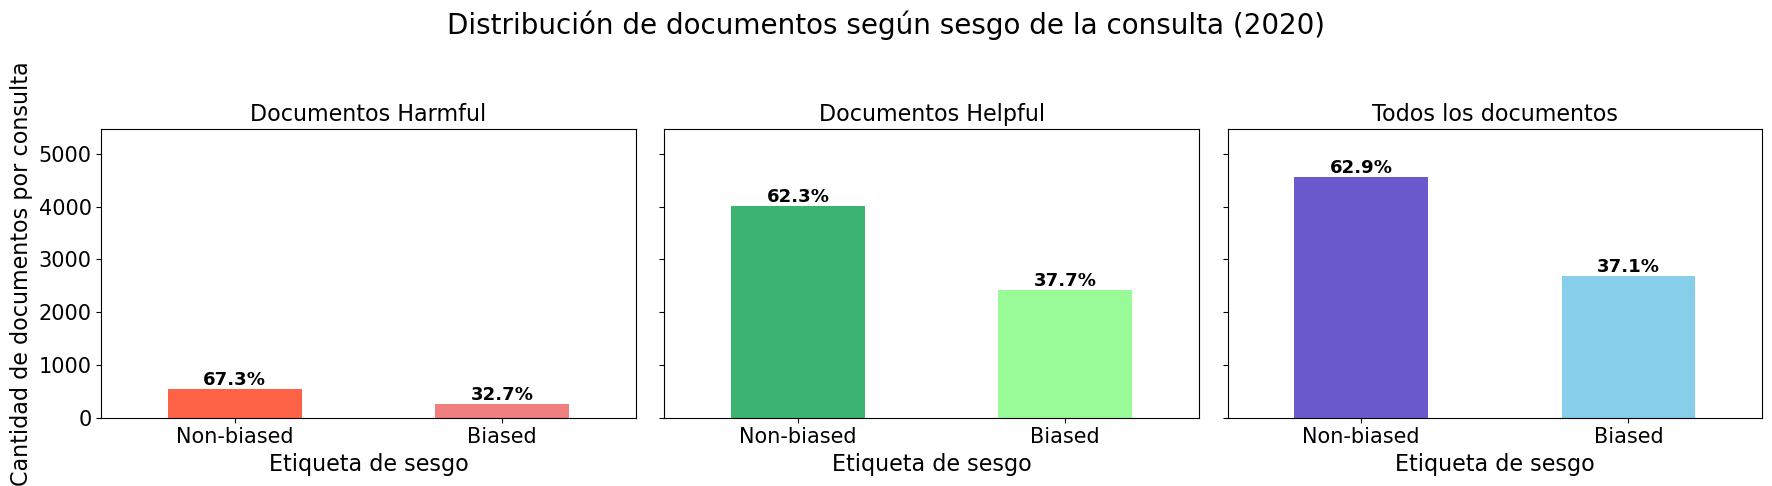

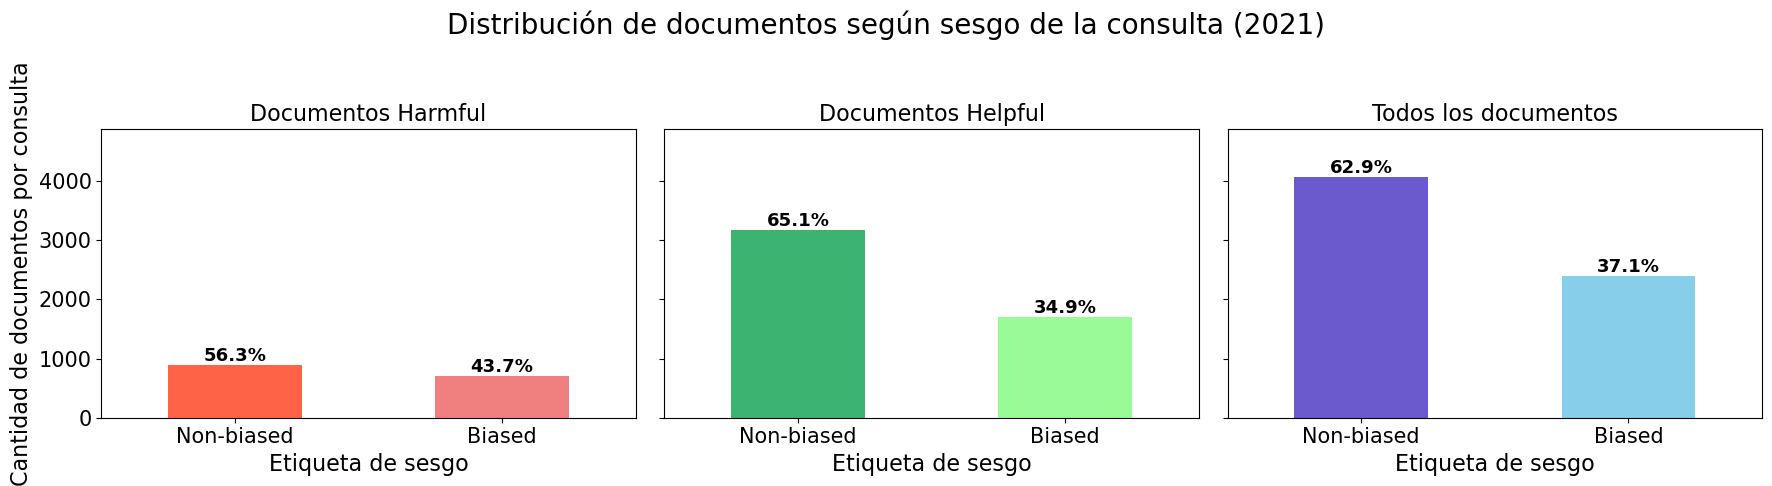

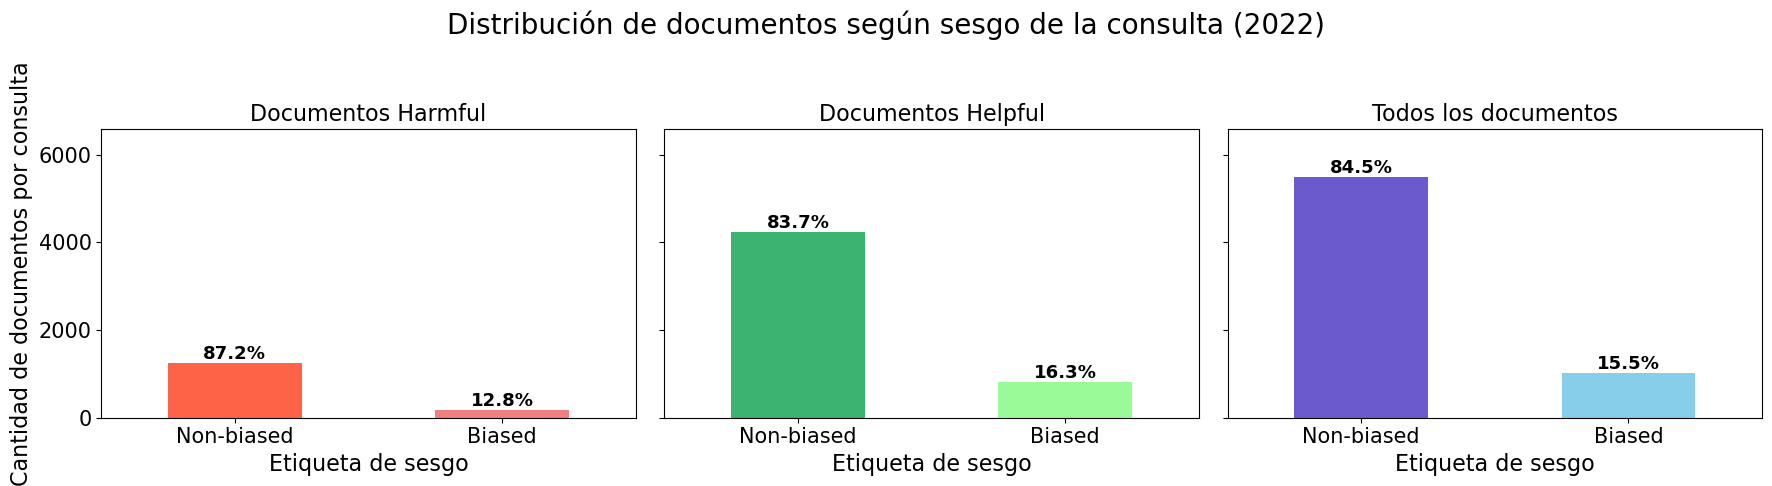

In [28]:
# Crear los 3 histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

def add_percentages(ax, counts):
    total = sum(counts)
    max_height = max(counts)
    ax.set_ylim(0, max_height * 1.2)
    for i, v in enumerate(counts):
        percentage = (v / total) * 100
        ax.text(i, v, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=13, fontweight='bold')


# Harmful
harmful_counts = qrels_2020_bias[qrels_2020_bias["category"] == "harmful"]["bias_label"].value_counts()
harmful_counts.plot(kind="bar", ax=axes[0], color=["tomato", "lightcoral"])
add_percentages(axes[0], harmful_counts)
axes[0].set_title("Documentos Harmful")
axes[0].set_xlabel("Etiqueta de sesgo")
axes[0].set_ylabel("Cantidad de documentos por consulta")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Helpful
helpful_counts = qrels_2020_bias[qrels_2020_bias["category"] == "helpful"]["bias_label"].value_counts()
helpful_counts.plot(kind="bar", ax=axes[1], color=["mediumseagreen", "palegreen"])
add_percentages(axes[1], helpful_counts)
axes[1].set_title("Documentos Helpful")
axes[1].set_xlabel("Etiqueta de sesgo")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Ambos
total_counts = qrels_2020_bias["bias_label"].value_counts()
total_counts.plot(kind="bar", ax=axes[2], color=["slateblue", "skyblue"])
add_percentages(axes[2], total_counts)
axes[2].set_title("Todos los documentos")
axes[2].set_xlabel("Etiqueta de sesgo")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle("Distribución de documentos según sesgo de la consulta (2020)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#------------------2021

# Crear los 3 histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Harmful
harmful_counts = qrels_2021_bias[qrels_2021_bias["category"] == "harmful"]["bias_label"].value_counts()
harmful_counts.plot(kind="bar", ax=axes[0], color=["tomato", "lightcoral"])
add_percentages(axes[0], harmful_counts)
axes[0].set_title("Documentos Harmful")
axes[0].set_xlabel("Etiqueta de sesgo")
axes[0].set_ylabel("Cantidad de documentos por consulta")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Helpful
helpful_counts = qrels_2021_bias[qrels_2021_bias["category"] == "helpful"]["bias_label"].value_counts()
helpful_counts.plot(kind="bar", ax=axes[1], color=["mediumseagreen", "palegreen"])
add_percentages(axes[1], helpful_counts)
axes[1].set_title("Documentos Helpful")
axes[1].set_xlabel("Etiqueta de sesgo")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Ambos
total_counts = qrels_2021_bias["bias_label"].value_counts()
total_counts.plot(kind="bar", ax=axes[2], color=["slateblue", "skyblue"])
add_percentages(axes[2], total_counts)
axes[2].set_title("Todos los documentos")
axes[2].set_xlabel("Etiqueta de sesgo")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle("Distribución de documentos según sesgo de la consulta (2021)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#------------------2022

# Crear los 3 histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Harmful
harmful_counts = qrels_2022_bias[qrels_2022_bias["category"] == "harmful"]["bias_label"].value_counts()
harmful_counts.plot(kind="bar", ax=axes[0], color=["tomato", "lightcoral"])
add_percentages(axes[0], harmful_counts)
axes[0].set_title("Documentos Harmful")
axes[0].set_xlabel("Etiqueta de sesgo")
axes[0].set_ylabel("Cantidad de documentos por consulta")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Helpful
helpful_counts = qrels_2022_bias[qrels_2022_bias["category"] == "helpful"]["bias_label"].value_counts()
helpful_counts.plot(kind="bar", ax=axes[1], color=["mediumseagreen", "palegreen"])
add_percentages(axes[1], helpful_counts)
axes[1].set_title("Documentos Helpful")
axes[1].set_xlabel("Etiqueta de sesgo")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Ambos
total_counts = qrels_2022_bias["bias_label"].value_counts()
total_counts.plot(kind="bar", ax=axes[2], color=["slateblue", "skyblue"])
add_percentages(axes[2], total_counts)
axes[2].set_title("Todos los documentos")
axes[2].set_xlabel("Etiqueta de sesgo")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.suptitle("Distribución de documentos según sesgo de la consulta (2022)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()